In [45]:
from openai import OpenAI
import json
import pandas as pd
from tqdm import tqdm
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import risk_models
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List
from openai import OpenAI
import os
import re
import pandas as pd
from tqdm import tqdm
import yfinance as yf
from gurobipy import Model, GRB, quicksum
import warnings
from dotenv import load_dotenv
import matplotlib.colors as mcolors
from IPython.display import display

load_dotenv()

warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False)  # Prevent splitting
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_rows', None)           # Optional: Show all rows

api_key = os.getenv("PPLX")

# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "WMT"] # 1
# tickers = ["AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 2
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 3
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE", "V"] # 4
# tickers = ["AAPL", "MSFT", "NVDA", "GOOGL", "META", "JPM", "XOM", "UNH", "WMT", "HD", "CAT", "PLD", "NEE", "V", "AMD"] # 6% better
# tickers = ["MS", "BAC", "CVX", "PFE", "PEP", "COST", "NFLX", "INTC", "LMT", "CSCO", "AXP", "AMZN", "TMUS", "TM", "DUK"]
# tickers = ["CVX", "PFE", "NFLX", "LMT", "TM", "PLTR", "OKTA", "MAR", "MCD", "SBUX", "EBAY", "MRNA", "BHP", "TGT", "EOG"]
tickers = [
    'NVDA', 'AMD', 'MSFT', 'AAPL', 'INTC', 'PLTR',  # Technology
    'TSLA', 'AMZN', 'SBUX', 'TGT', 'NFLX', 'MCD',  # Consumer Discretionary
    'HOOD', 'BAC', 'JPM', 'MS', 'V', 'SCHW',  # Financials
    'ZG', 'PLD', 'WELL', 'SPG', 'PSA', 'EQR',  # Real Estate
    'GEV', 'XOM', 'DUK', 'NEE', 'EOG', 'SLB',  # Energy
    'TEM', 'UNH', 'PFE', 'MRNA', 'ABBV', 'MDT',  # Healthcare
    'CAT', 'BA', 'LMT', 'DE', 'GD', 'HON',  # Industrials
    'PCT', 'NEM', 'LIN', 'APD', 'FCX', 'MLM',  # Materials
    'GOOG', 'TMUS', 'META', 'DIS', 'VZ', 'CMCSA',  # Communication Services
    'COST', 'PEP', 'WMT', 'KO', 'PG', 'MO'  # Consumer Staples
]

stock_categories = [
    "Technology",
    "Consumer Discretionary",
    "Finance",
    "Real Estate",
    "Energy", 
    "Healthcare",
    "Industrial",
    "Material",
    "Communication",
    "Consumer Staples"
]

In [46]:
# CHANGE THESE!!
appendage = "nvda60"
iteration = "temp0_16"

# always just appends
init_news_path = f"assets/init_news_reports.json"
stock_data_path = f"assets/stock_data.json"

pft_path = f"assets/portfolio_{appendage}.csv"
stock_price_history_image_path = f'figures/stock_price_history_{appendage}.png'

grid_image_path = f'assets/output_{appendage}_{iteration}.png'
grid_image_sparse_path = f'assets/output_sparse_{appendage}_{iteration}.png'
weights_coord_path = f"assets/weights_coord_{appendage}_{iteration}.json"
weights_coord_sparse_path = f"assets/weights_coord_sparse_{appendage}_{iteration}.json"
weights_llm_path = f"assets/weights_llm_{appendage}_{iteration}.json"
weights_llm_sparse_path = f"assets/weights_llm_sparse_{appendage}_{iteration}.json"
weights_opt_path = f"assets/weights_opt_{appendage}_{iteration}.json"
pft_value_over_time_path = f'figures/pft_value_over_time_{appendage}_{iteration}.png'
risk_path = f'figures/risk_{appendage}_{iteration}.png'
heatmap_path = f"figures/heatmap_{appendage}_{iteration}.png"
heatmap_all_path = f"figures/heatmap_all_{appendage}_{iteration}.png"
directory_path = f"assets/indiv/{appendage}_{iteration}"
directory_path_sparse = f"assets/indiv/{appendage}_{iteration}_sparse"
pnl_path = f"figures/pnl_{appendage}_{iteration}.png"

rerun_llm, rerun_opt, rerun_coord, rerun_llm_sparse, rerun_coord_sparse = True, True, True, True, True

In [47]:
runs = [13, 14, 15, 16]

weights_coord_path_prefix = f"assets/weights_coord_nvda60_temp0_[num].json"
weights_coord_sparse_path_prefix = f"assets/weights_coord_sparse_nvda60_temp0_[num].json"
weights_llm_path_prefix = f"assets/weights_llm_nvda60_temp0_[num].json"
weights_llm_sparse_path_prefix = f"assets/weights_llm_sparse_nvda60_temp0_[num].json"
weights_opt_path_prefix = f"assets/weights_opt_nvda60_temp0_[num].json"

status_path_prefix = f"assets/status_nvda60_temp0_[num].json"
status_sparse_path_prefix = f"assets/status_sparse_nvda60_temp0_[num].json"

all_weights_paths = [weights_coord_path_prefix, weights_coord_sparse_path_prefix, weights_llm_path_prefix, weights_llm_sparse_path_prefix, weights_opt_path_prefix]

all_weights = [None] * len(all_weights_paths)

In [48]:
def save_data(data, file_path=stock_data_path):
    """
    Saves the dictionary 'data' to a JSON file at 'file_path'.
    """
    with open(file_path, 'w') as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {file_path}")

def load_data(file_path=stock_data_path):
    """
    Loads JSON data from 'file_path' and returns it as a dictionary.
    """
    with open(file_path, 'r') as fp:
        data = json.load(fp)
    print(f"Data loaded from {file_path}")
    return data

def patch_data(
    tickers,
    file_path=stock_data_path
):
    """
    Load existing data from file_path, then patch each month's dictionary
    to include 'MSTR' and 'SMCI' using Perplexity.ai's OpenAI-like client calls.
    Finally, save the patched data back to file_path.
    """

    # 1) Load the existing data
    data = load_data(file_path)

    # 2) Set up your client, months, system prompt, etc.
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")

    months = [
        "January", "Febuary", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    
    system_prompt = {
        "role": "system",
        "content": (
            "Show me key news on [Company X] (I'll provide you the stock ticker) from [Date Range]. This list isn't exhaustive—earnings, leadership changes, regulatory updates, major headlines, M&A, industry trends, product launches, analyst opinions, investor activism, competitor moves—but only pick what's most representative for [Company X]'s stock performance. If other items seem more important, include them. Summarize in bullet points; avoid complete sentences; aim for maximum information. You don't have to include everything, just the key pieces. Keep final summary around 400 words."
        )
    }

    # 3) Patch each month's dictionary if tickers dont exist
    for i, monthly_data in enumerate(data):
        for j in tqdm(range(len(tickers))):
            ticker = tickers[j]
            if ticker not in monthly_data:
                # Build the request messages for the missing ticker
                messages = [
                    system_prompt,
                    {
                        "role": "user",
                        "content": f"What happened to {ticker} in {months[i]} 2024?"
                    }
                ]

                # Make the API call
                response = client.chat.completions.create(
                    model="llama-3.1-sonar-large-128k-online",
                    messages=messages,
                )

                # Save the result in the monthly dictionary
                monthly_data[ticker] = {"news": response.choices[0].message.content}
                # print(f'patched: month {months[i]}\t{ticker}')
            # else:
                # print(f'skipping: {ticker}')
            
            # save_data(data, file_path)

    # 4) Save the patched data back to the JSON file
    save_data(data, file_path)

In [49]:
def get_last_trading_day_of_month(year, month, exchange='NYSE'):
    # Create a calendar for the specified exchange
    calendar = mcal.get_calendar(exchange)
    
    # Get the last day of the specified month
    if month == 12:
        last_day = datetime.datetime(year + 1, 1, 1) - datetime.timedelta(days=1)
    else:
        last_day = datetime.datetime(year, month + 1, 1) - datetime.timedelta(days=1)
    
    # Get the schedule for the month
    schedule = calendar.schedule(start_date=f"{year}-{month:02d}-01", end_date=last_day)
    
    # If the schedule is empty, there were no trading days this month
    if schedule.empty:
        return None
    
    # Return the last trading day
    return schedule.index[-1].date().day

def get_stock_price(tickers, date):
    prices = yf.download(tickers, start=date, end=date + datetime.timedelta(days=1))
    prices = prices["Adj Close"].dropna(how="all")
    prices = prices.values.tolist()
    return prices[0]

def get_closing_prices(data_loaded):
    year = 2024
    for month in range(1, 13):
        date = get_last_trading_day_of_month(year, month)
        datetime_obj = datetime.datetime(year, month, date)
        
        missing_tickers = []
        missing_indices = []
        for i, ticker in enumerate(tickers):
            ticker_data = data_loaded[month-1][ticker]
            if "price" not in ticker_data:
                missing_tickers.append(ticker)
                missing_indices.append(i)
            else:
                if np.isnan(ticker_data['price']):
                    missing_tickers.append(ticker)
                    missing_indices.append(i)

        if missing_indices:
            prices = get_stock_price(missing_tickers, datetime_obj)
            if type(prices) != type([]):
                prices = [prices]

            for i, (ticker, j) in enumerate(zip(missing_tickers, missing_indices)):
                data_loaded[month-1][ticker]['price'] = prices[i]

    save_data(data_loaded)

# get_stock_price('ZG', datetime.datetime(2024, 1, get_last_trading_day_of_month(2024, 1)))

data_loaded = load_data()
get_closing_prices(data_loaded)

Data loaded from assets/stock_data.json
Data saved to assets/stock_data.json


In [50]:
columns = []
categories = ['all', 'llm', 'opt']
for c in categories:
    for ticker in tickers:
        columns.append(f'{c} {ticker}')

In [51]:
def extract_month(x):
    m = re.search(r"month\s+(\d+)", x)
    return int(m.group(1)) if m else None

In [52]:
verbose = False

for i, path_template in enumerate(all_weights_paths):
    df = None

    for r in runs:
        path = path_template.replace("[num]", str(r))

        df_cur = pd.read_json(path) 

        if f"coord_{appendage}" in path or f"coord_sparse_{appendage}" in path: # status is not None
            try:
                df_cur = pd.DataFrame(df_cur.values.tolist(), columns=['status']+columns) 
            except Exception as e:
                df_cur = pd.DataFrame(df_cur.values.tolist(), columns=columns) 

            df_filtered=df_cur.copy(deep=True)

            df_filtered['month_num'] = df_filtered['status'].apply(extract_month)
            df_filtered['next_month_num'] = df_filtered['month_num'].shift(-1)
            mask = (df_filtered['month_num'] != df_filtered['next_month_num']) | df_filtered['next_month_num'].isna()
            df_filtered = df_filtered[mask]
            df_filtered.set_index('status', inplace=True)

            df_cur=df_filtered.reset_index(drop=True)
        else:
            df_cur = pd.DataFrame(df_cur.values.tolist(), columns=tickers) 

        df_cur.reset_index(drop=True)

        if verbose:
            print("display(df_cur)")
            display(df_cur)

        if df is None:
            df = df_cur
        else:
            df += df_cur  

    if verbose:
        print("display(df)")
        display(df)

    # Step 3: Divide each element in `df` by the number of runs
    df /= len(runs)

    # Convert the dataframe back to a list of lists and store it in `all_weights`
    all_weights[i] = df.values.tolist()

weights_coord, weights_coord_sparse, weights_llm, weights_llm_sparse, weights_opt = all_weights

In [53]:
def backtest(_weights):
    i = 0
    initial_capital = 10000
    portfolio_value = initial_capital

    portfolio_history = [portfolio_value]
    # Create a DataFrame to track monthly PnL for each ticker
    monthly_pnl = pd.DataFrame(0.0, index=range(12), columns=tickers)

    while i < 11:
        # ---- 1) Get the weights for this month (end of month i) ----
        weights = _weights[i]

        # ---- 2) Buy using these weights ----
        shares = []
        buy_prices = []
        initial_capital = portfolio_value

        for j, ticker in enumerate(tickers):
            buy_price = data_loaded[i][ticker]['price']
            buy_prices.append(buy_price)

            allocation = initial_capital * weights[j]  # portion of capital
            shares_bought = allocation / buy_price if buy_price > 0 else 0
            shares.append(shares_bought)

            # Deduct spent cash
            portfolio_value -= shares_bought * buy_price

        # ---- 3) Sell at month i+1 (end of next month), record PnL per ticker ----
        i += 1
        for j, ticker in enumerate(tickers):
            sell_price = data_loaded[i][ticker]['price']
            # PnL for this ticker in month i-1 (e.g. row 0 if i=1 now)
            pnl = shares[j] * (sell_price - buy_prices[j])
            monthly_pnl.loc[i - 1, ticker] = pnl  # store PnL

            # Update portfolio value by the proceeds of selling
            portfolio_value += shares[j] * sell_price

        portfolio_history.append(portfolio_value)

    print("Final Portfolio Value:", portfolio_value)
    # Return both the total portfolio value history and the per-ticker monthly PnL
    return portfolio_history, monthly_pnl

# For example, the coordinated strategy:
portfolio_history_coordinated, pnl_coordinated = backtest(weights_coord)
portfolio_history_coordinated_sparse, pnl_coordinated_sparse = backtest(weights_coord_sparse)

# Or the pure OPT strategy:
portfolio_history_opt, pnl_opt = backtest(weights_opt)

# Or the pure LLM strategy:
portfolio_history_llm, pnl_llm = backtest(weights_llm)
portfolio_history_llm_sparse, pnl_llm_sparse = backtest(weights_llm_sparse)

# Averaged LLM + OPT
portfolio_history_avg, pnl_avg = backtest(avg_histories)
portfolio_history_avg_sparse, pnl_avg_sparse = backtest(avg_sparse_histories)

Final Portfolio Value: 13572.959531370961
Final Portfolio Value: 13769.210575342671
Final Portfolio Value: 14119.310376124826
Final Portfolio Value: 13043.541928736064
Final Portfolio Value: 13431.764185222772
Final Portfolio Value: 13578.144354087353
Final Portfolio Value: 13777.037874716509


In [54]:
# avg of pure_opt and pure_llm plan
avg_histories = (np.array(weights_opt) + np.array(weights_llm)) / 2
row_sums = avg_histories.sum(axis=1, keepdims=True)  # Sum of each row
normalized_array = avg_histories / row_sums  # Divide each element by its row sum
avg_histories = normalized_array.tolist()

avg_sparse_histories = (np.array(weights_opt) + np.array(weights_llm_sparse)) / 2
row_sums = avg_sparse_histories.sum(axis=1, keepdims=True)
normalized_array = avg_sparse_histories / row_sums
avg_sparse_histories = normalized_array.tolist()

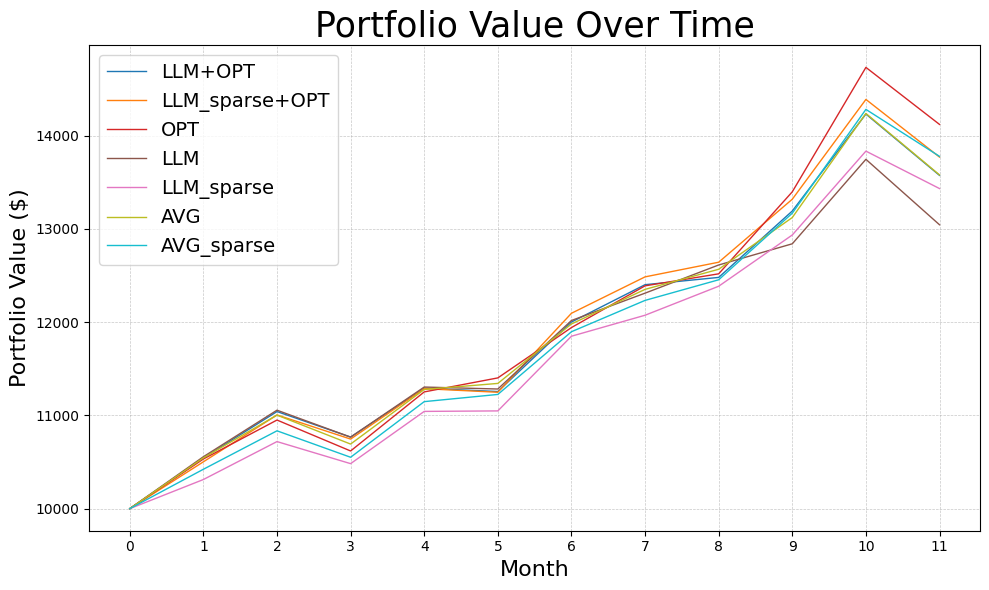

In [55]:
import matplotlib.cm as cm

# Create labels for months 0 through 11
months = [f"{i}" for i in range(12)]

plt.figure(figsize=(10, 6))

num_plots = 7
colors = cm.get_cmap('tab10', num_plots).colors

# Plot as a line chart with markers
plt.plot(months, portfolio_history_coordinated, linestyle='-', linewidth=1, label='LLM+OPT', color=colors[0])
plt.plot(months, portfolio_history_coordinated_sparse, linestyle='-', linewidth=1, label='LLM_sparse+OPT', color=colors[1])
plt.plot(months, portfolio_history_opt, linestyle='-', linewidth=1, label='OPT', color=colors[2])
plt.plot(months, portfolio_history_llm, linestyle='-', linewidth=1, label='LLM', color=colors[3])
plt.plot(months, portfolio_history_llm_sparse, linestyle='-', linewidth=1, label='LLM_sparse', color=colors[4])
plt.plot(months, portfolio_history_avg, linestyle='-', linewidth=1, label='AVG', color=colors[5])
plt.plot(months, portfolio_history_avg_sparse, linestyle='-', linewidth=1, label='AVG_sparse', color=colors[6])

# Add a title, axis labels, and grid
plt.title("Portfolio Value Over Time", fontsize=25)
plt.xlabel("Month", fontsize=16)
plt.ylabel("Portfolio Value ($)", fontsize=16)

# Improve grid styling
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend with larger font size
plt.legend(fontsize=14, loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.savefig(pft_value_over_time_path, dpi=500, bbox_inches='tight')  
plt.show()